In [164]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import numpy as np
from statsmodels.discrete.discrete_model import NegativeBinomial

sns.set_style('ticks')

In [88]:
import blist
from collections import namedtuple
import pysam
from sourmash_lib import Estimators
from sourmash_lib import MinHash
from khmer import Countgraph
from khmer import reverse_hash
import mmh3

In [80]:
K = 25

In [183]:
class CountingMinHash(object):
    
    KmerHash = namedtuple('KmerHash', ['hashval', 'count'])
    
    def __init__(self, K, N, cg):
        '''A MinHash sketch for $k$-mers which counts the abundance of its corresponding
        nodes using a count-min sketch.
        
        Args:
            K (int): The length of the $k$-mers.
            N (int): Number of hashes in the sketch.
            cg (Countgraph): The count-min sketch.
        '''
        self.cg = cg
        self.K = K
        self.N = N
        
        self.sig = blist.sortedlist(key=lambda h: h.hashval)
    
    def add_kmer(self, kmer):
        '''Add a string $k$-mer and its count to the sketch.
        
        Args:
            kmer (str): The $k$-mer. Must have length equal to K.
        '''
        assert len(kmer) == self.K
        h = mmh3.hash(kmer)
        if not self.sig or h < self.sig[-1].hashval:
            hashval = self.KmerHash(hashval=h, count=self.cg.get(kmer))
            self.sig.add(hashval)
        if len(self.sig) > self.N:
            self.sig.pop()
    
    def add_sequence(self, sequence):
        '''Add the $k$-mers from a sequence.
        
        Args:
            sequence (str): The sequence.
        '''
        for kmer in self.kmers(sequence):
            self.add_kmer(kmer)
    
    def kmers(self, sequence):
        '''Generator for the $k$-kmers in a sequence.
        
        Args:
            sequence (str): The sequence.
        Yields:
            str: Substrings of length $K$ in a sliding window across the sequence.
        '''
        K = self.K
        for i in range(0, len(sequence)-K+1):
            yield sequence[i:i+K]
    
    def hashes(self):
        '''Get all the hashes in the MinHash sketch.
        
        Returns:
            ndarray: The hashes from the sketch.
        '''
        return np.array([item.hashval for item in self.sig])
    
    def counts(self):
        '''Get all the counts from the hashes in the sketch.
        
        Returns:
            ndarray: The counts.
        '''
        return np.array([item.count for item in self.sig])
    
    def __str__(self):
        return '<CountingMinHash K={0} N={1} n={2}>'.format(self.K, self.N, len(self.sig))

In [74]:
cg = Countgraph(K, 1e9, 4)

In [76]:
cg.consume_fasta('../data/Asterionellopsis_glacialis_CCMP1581_SRR1300451_MMETSP1394.reads.fasta')

(26442392, 685830574)

In [75]:
alns = pysam.AlignmentFile('../data/Asterionellopsis_glacialis_CCMP1581_SRR1300451_MMETSP1394.Trinity.fasta.aln.bam.bam',
                           mode='rb')

In [262]:
def get_scipy_params_nbinom(model):
    mu = model.predict()[0]   # use this for mean if not constant
    #mu = np.exp(model.params[0])   # shortcut, we just regress on a constant
    alpha = model.params[1]
    Q = 1
    #if loglike_method == 'nb1':
    #    Q = 1
    #elif loglike_method == 'nb2':    
    #    Q = 0

    n = 1. / alpha * mu**Q
    p = size / (size + mu)
    
    return n, p, mu

Optimization terminated successfully.
         Current function value: 3.825976
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
                     NegativeBinomial Regression Results                      
Dep. Variable:                      y   No. Observations:                  800
Model:               NegativeBinomial   Df Residuals:                      799
Method:                           MLE   Df Model:                            0
Date:                Mon, 31 Oct 2016   Pseudo R-squ.:                   0.000
Time:                        13:43:25   Log-Likelihood:                -3060.8
converged:                       True   LL-Null:                       -3060.8
                                        LLR p-value:                       nan
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          3.1127      0.019    168.1

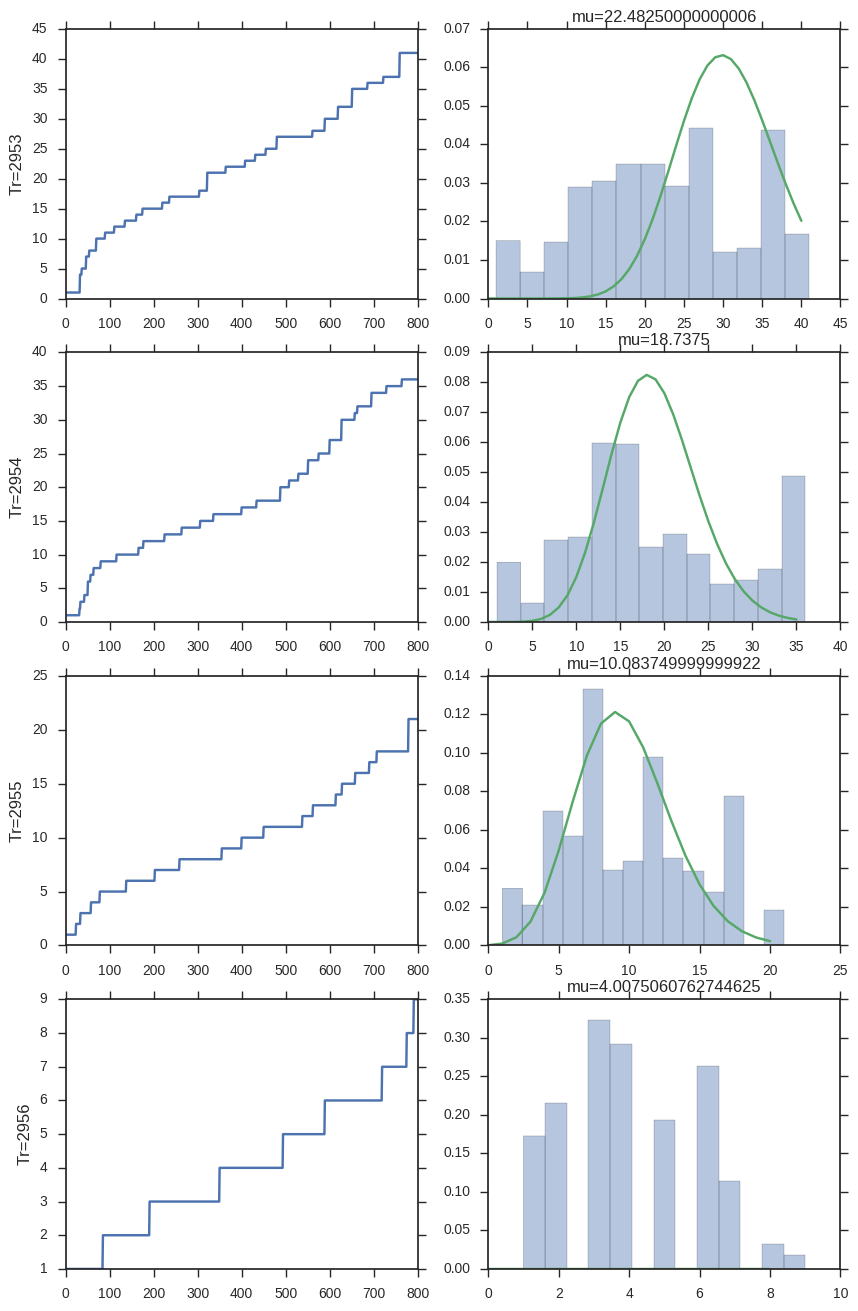

In [266]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10,16), sharey=False)
for pid, tid in enumerate(range(2953,2957)):
    cg = Countgraph(K, 1e7, 4)
    cmh = CountingMinHash(K, 800, cg)
    for read in alns.fetch(alns.get_reference_name(tid)):
        cg.consume(read.seq)
    for read in alns.fetch(alns.get_reference_name(tid)):
        cmh.add_sequence(read.seq)
    
    counts = cmh.counts()
    model = NegativeBinomial(counts,np.ones_like(counts)).fit()
    print(model.summary())
    
    n, p, mu = get_scipy_params_nbinom(model)
    
    ax[pid, 0].plot(sorted(counts))
    ax[pid, 0].set_ylabel('Tr={0}'.format(tid), size='large')
    
    sns.distplot(counts, kde=False, ax=ax[pid,1], norm_hist=True)
    ax[pid, 1].plot(range(0,max(counts)), stats.nbinom.pmf(range(0,max(counts)), n=n, p=p, loc=0), '-')
    ax[pid, 1].set_title( label='mu={0}'.format(mu))


#plt.tight_layout()

In [131]:
alns.get_tid('c2813_g1_i1_len=1355_path=[5451:0-1348_4585:1349-1351_8049:1352-1354]')

2953